In [1]:
import random
import dill 
import glob 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial as spatial
import sys 
sys.path.append('..//CPN//')
import numpy as np 
import statsmodels.api as sm
from tqdm import tqdm_notebook, tqdm

In [2]:
%matplotlib notebook

In [3]:
folder1 = '..//simulations/multivariable_simulations//'
folder2 = '/home/thejasvib/simdisk2/cpn_sims/the_cocktail_party_nightmare/simulations/multivariable_simulations/'
results_folder = [folder1, folder2]

In [4]:
x = [1,2,3]
q = random.sample(x,2)

In [5]:
all_results = [glob.glob(folder+'*.simresults') for folder in results_folder]
sim_results = all_results[0] + all_results[1]

some_sim_results = random.sample(sim_results, int(len(sim_results)*0.5))

In [6]:
## A series of functions to parse the  simulation output
def get_run_uuid(sim_id):
    return(sim_id['uuid'])
def get_num_echoes_heard(sim_data):
    '''
    '''
    num_echoes_heard = np.sum(sim_data[0])
    return(num_echoes_heard)

which_echo = {True: 1 , False:0}

def get_echoids(sim_data, heard=True):
    '''
    '''
    echo_indices = np.argwhere(sim_data[0]==which_echo[heard]).flatten()
    return(echo_indices)    

def get_echo_levels(sim_data, heard=True):
    '''
    '''
    echo_ids = get_echoids(sim_data, heard)
    
    echo_levels = sim_data[1]['target_echoes'].loc[echo_ids,'level']
    return(echo_levels)
    

def get_group_size(sim_data):
    ''' This function is necessary because of the
    stupid way I stored the parameter sets using classes
    '''
    num_bats_in_group = sim_data[0].size +1 
    return(num_bats_in_group)

def split_by_groupsize(df):
    all_subdfs = []
    group_sizes = np.unique(df['groupsize'])
    for each_groupsize in group_sizes:
        subdf = df[df['groupsize']==each_groupsize]
        all_subdfs.append(subdf)
    return(group_sizes, all_subdfs)



def get_individual_positions(sim_data):
    '''
    '''
    _, _b, geometry = sim_data
    positions = geometry['positions']
    return(positions)


def get_detection_distance(sim_data, heard=True):
    '''
    '''
    echo_inds = get_echoids(sim_data,heard)
    individuals_inds = echo_inds +1 # because focal individ is 0 index
    all_positions = get_individual_positions(sim_data)
    heard_individual_positions = all_positions[individuals_inds,:]
    focal_ind = all_positions[0,:]
    distances = spatial.distance
    
    positions_of_relevance = np.row_stack((focal_ind, heard_individual_positions))
    distances = spatial.distance_matrix(positions_of_relevance, 
                                        positions_of_relevance)[1:,0]
    return(distances)

def get_simulation_results(simulation_output, heard=True):
    '''Extract the angles, radial distances and echo levels 
    of echoes of interest
    '''
    sim_ids, sim_data = simulation_output
    groupsize = get_group_size(sim_data)
    num_echoes_heard = get_num_echoes_heard(sim_data)
    uuid = get_run_uuid(sim_ids)

def load_simresult(path_to_simresult):
    '''
    '''
    with open(path_to_simresult, 'rb') as sim:
        output = dill.load(sim)
    return(output)
    

In [7]:
### Load the data : this needs a decent amount of RAM !! and takes some time - remember this. 

In [8]:
all_simulation_data = []

for each in tqdm(sim_results):
    with open(each, 'rb') as sim:
        output = pickle.load(sim)
    all_simulation_data.append(output)
    

In [9]:
all_simulation_data = Parallel(n_jobs=64)(delayed(load_simresult)(each) for each in tqdm(some_sim_results))

100%|██████████| 43200/43200 [18:36<00:00, 38.71it/s]  


In [10]:
len(all_simulation_data)

43200

In [11]:
random_seeds = [int(sim_result.split('_')[-2]) for sim_result in sim_results]

In [12]:
# DOUBLE CHECK to see that a random seed was not repeated. This is very unlikely anyway because we're using numbers
# ranging from 0 - 2^30. 

# The chance of uuids clashing is very low - and the chance of random seeds being the same is slightly higher? - anyway - 
# check that there are no repeats in random seed.
_ , counts = np.unique(random_seeds, return_counts=True)
np.unique(counts)

array([1, 2])

### Running the analysis of simulation talk :
Now let's assemble it all into one giant dataframe for better statistical analysis. I would like to run a series of analyses which try to explain the effect of the variables I changed on :

1) Number of conspecifics detected per call

2) Radial distance of conspecifics detected 

3) Azimuthal location of conspecifics detected 

In [13]:
one_sim = all_simulation_data[0]

In [14]:
sim_id, sim_data = one_sim

In [15]:
def extract_parameter_values(one_sim_result, variables_to_extract):
    '''
    Extracts the variables from the simulation result
    by extracting the values from the 
    'parameter set'
    
    Parameters
    -----------
    one_sim_results : tuple/list with 2 entries. 
                      entry 1 should have the simulation identifiers
                      entry 2 may be anything.

    variables_to_extract : list with str.
                           The names of the variables that are to be extracted.
                           Notes: 
                           If 'source_level' is one of the variables - only the 
                           emitted levels as dBSPL is output - the reference distance
                           is *ignored*.

    Returns
    --------
    param_set : list.
                A list with the numeric or Boolean values of each of the variables extracted. 
    '''
    sim_identifiers, sim_data = one_sim_result
    all_parameter_values = sim_identifiers['parameter_set']
    
    param_set_for_this_run = []
    for each in variables_to_extract:
        if each != 'source_level':
            param_set_for_this_run.append(all_parameter_values[each])
        elif each == 'source_level':
            param_set_for_this_run.append(all_parameter_values[each]['dBSPL'])
    
    return(param_set_for_this_run)
        
make_to_string = lambda X: str(X)

def join_all_parameters(parameter_list):
    '''
    '''
    params_as_string = map(make_to_string, parameter_list)
    param_joined = '*'.join(params_as_string)
    return(param_joined)
    

In [16]:
variables_of_interest = ['heading_variation', 'echocall_duration','atmospheric_attenuation','min_spacing','source_level',
                        'interpulse_interval', 'implement_shadowing']

In [17]:
run_parameters = { each:[] for each in variables_of_interest}
run_parameters ['np.random.seed'] = []
run_parameters['detected_neighbours'] = []
run_parameters['param_id'] = []

for each in all_simulation_data:
    seed_number = each[0]['np.random.seed']
    run_parameters['np.random.seed'].append(seed_number)
    num_neighbours = get_num_echoes_heard(each[1])
    run_parameters['detected_neighbours'].append(num_neighbours)
    
    parameters = extract_parameter_values(each, variables_of_interest)
    param_id = join_all_parameters(parameters)
    run_parameters['param_id'].append(param_id)
    
    for variable, value in zip(variables_of_interest, parameters):
        run_parameters[variable].append(value)
    

In [18]:
all_run_data = pd.DataFrame(data=run_parameters)

In [19]:
all_run_data.head()

,atmospheric_attenuation,detected_neighbours,echocall_duration,heading_variation,implement_shadowing,interpulse_interval,min_spacing,np.random.seed,param_id,source_level
0,-1,1,0.0010,90,False,0.100,1.0,479679573,90*0.001*-1*1.0*100*0.1*False,100
1,-1,0,0.0010,90,True,0.025,1.0,287165708,90*0.001*-1*1.0*94*0.025*True,94
2,0,2,0.0010,90,False,0.100,1.0,193355102,90*0.001*0*1.0*100*0.1*False,100
3,0,0,0.0025,10,False,0.025,1.0,190997905,10*0.0025*0*1.0*100*0.025*False,100
4,-2,0,0.0010,10,True,0.050,1.0,134673671,10*0.001*-2*1.0*106*0.05*True,106


In [20]:
# check how many of each parameter set was run:
param_sets, counts = np.unique(all_run_data['param_id'], return_counts=True) 

In [21]:
# Check if the number of obtained parameter sets matches 432 - the expected number
len(param_sets)


432

In [22]:
# check what the general range of runs per parameter set we have :
np.percentile(counts, [5,50,95])

array([ 88., 100., 111.])

<IPython.core.display.Javascript object>


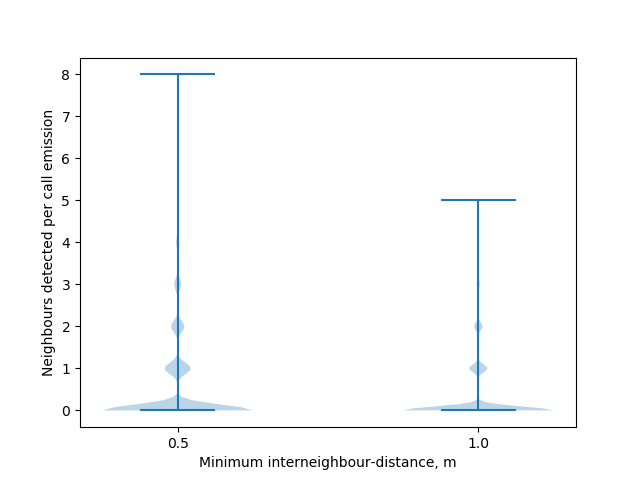

Text(0,0.5,'Neighbours detected per call emission')

In [23]:
by_spacing = all_run_data.groupby('min_spacing')
neighbours_by_spacing = [ np.array(df['detected_neighbours']) for value, df in by_spacing]
plt.figure()
plt.violinplot(neighbours_by_spacing)
plt.xticks([1,2],[0.5,1.0]); plt.xlabel('Minimum interneighbour-distance, m');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


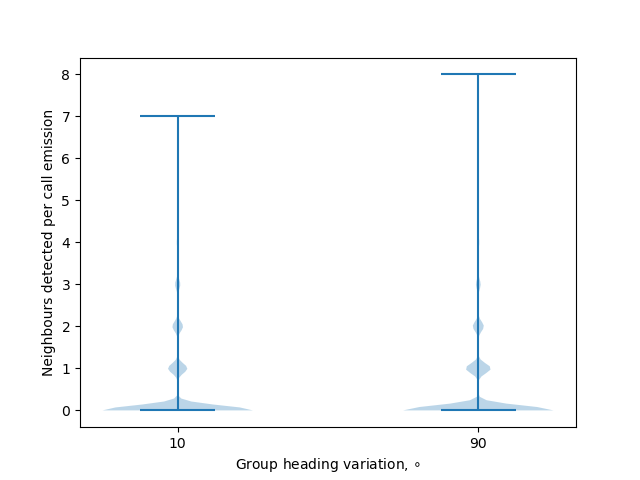

Text(0,0.5,'Neighbours detected per call emission')

In [24]:
by_heading = all_run_data.groupby('heading_variation')
neighbours_by_spacing = [ np.array(df['detected_neighbours']) for value, df in by_heading]
plt.figure()
plt.violinplot(neighbours_by_spacing)
plt.xticks([1,2],[10,90]); plt.xlabel('Group heading variation, $\circ$');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


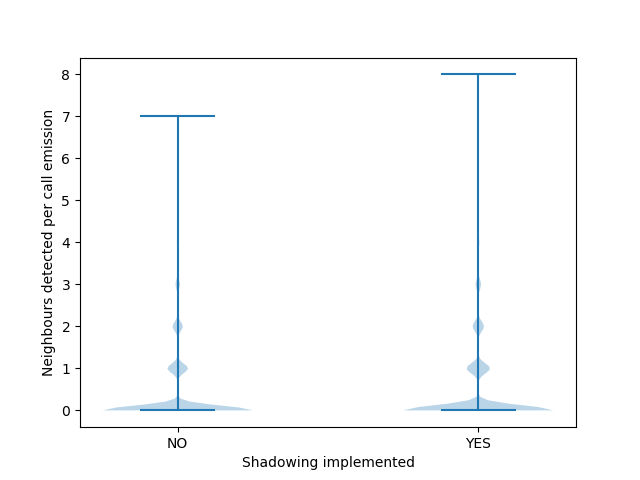

Text(0,0.5,'Neighbours detected per call emission')

In [25]:
by_shadowing = all_run_data.groupby('implement_shadowing')
neighbours_by_shadowing = [ np.array(df['detected_neighbours']) for value, df in by_shadowing]
plt.figure()
plt.violinplot(neighbours_by_shadowing)
plt.xticks([1,2],['NO', 'YES']); plt.xlabel('Shadowing implemented');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


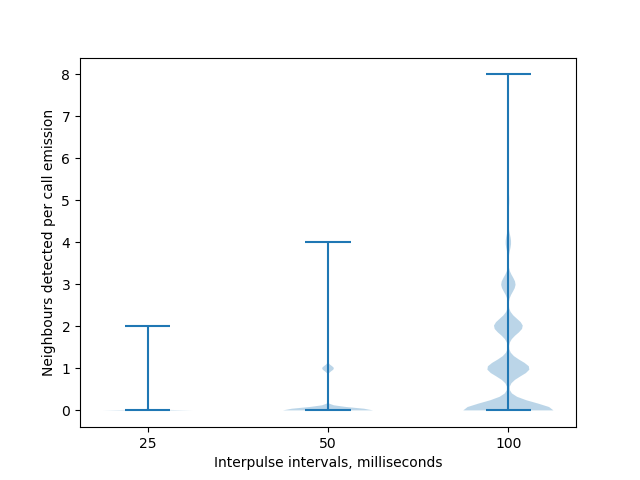

Text(0,0.5,'Neighbours detected per call emission')

In [26]:
by_ipi = all_run_data.groupby('interpulse_interval')
neighbours_by_ipi = [ np.array(df['detected_neighbours']) for value, df in by_ipi]
plt.figure()
plt.violinplot(neighbours_by_ipi)
plt.xticks([1,2,3],[25, 50, 100]); plt.xlabel('Interpulse intervals, milliseconds');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


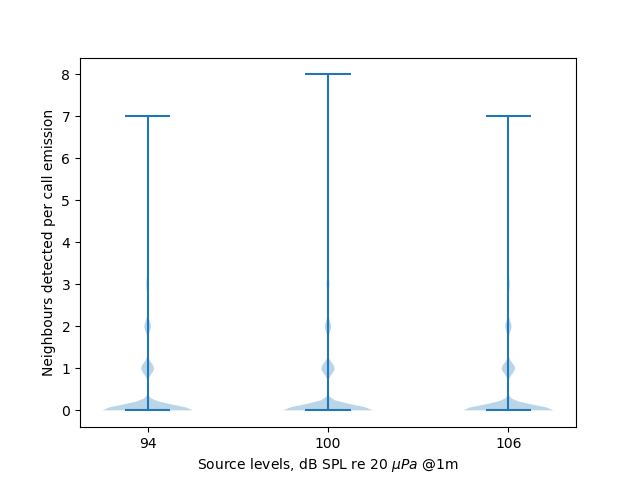

Text(0,0.5,'Neighbours detected per call emission')

In [27]:
by_sl = all_run_data.groupby('source_level')
neighbours_by_sl = [ np.array(df['detected_neighbours']) for value, df in by_sl]
plt.figure()
plt.violinplot(neighbours_by_sl)
plt.xticks([1,2,3],[94, 100, 106]); plt.xlabel('Source levels, dB SPL re 20 $\mu Pa$ @1m');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


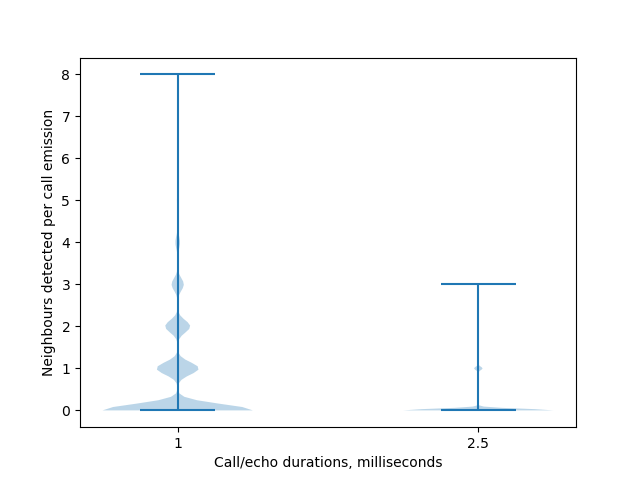

Text(0,0.5,'Neighbours detected per call emission')

In [28]:
by_duration = all_run_data.groupby('echocall_duration')
neighbours_by_duration = [ np.array(df['detected_neighbours']) for value, df in by_duration]
plt.figure()
plt.violinplot(neighbours_by_duration)
plt.xticks([1,2],[1, 2.5]); plt.xlabel('Call/echo durations, milliseconds');
plt.ylabel('Neighbours detected per call emission')

<IPython.core.display.Javascript object>


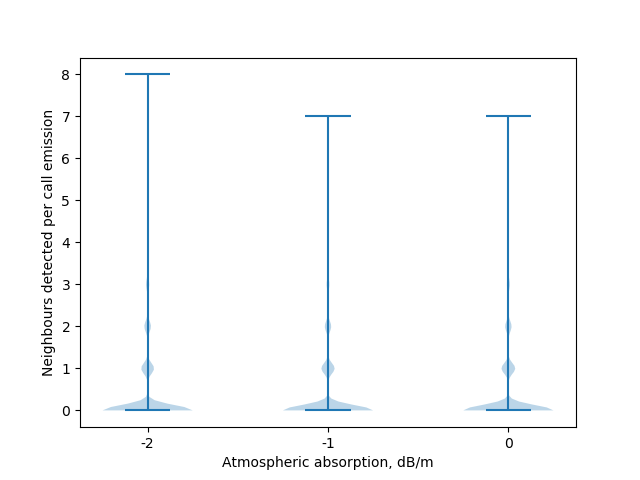

Text(0,0.5,'Neighbours detected per call emission')

In [29]:
by_attenuation = all_run_data.groupby('atmospheric_attenuation')
neighbours_by_atmabs = [ np.array(df['detected_neighbours']) for value, df in by_attenuation]
plt.figure()
plt.violinplot(neighbours_by_atmabs)
plt.xticks([1,2,3],[-2, -1, 0]); plt.xlabel('Atmospheric absorption, dB/m');
plt.ylabel('Neighbours detected per call emission')

## Which parameter set achieves an 'optimum' rate of neighbour detection ? 

<IPython.core.display.Javascript object>


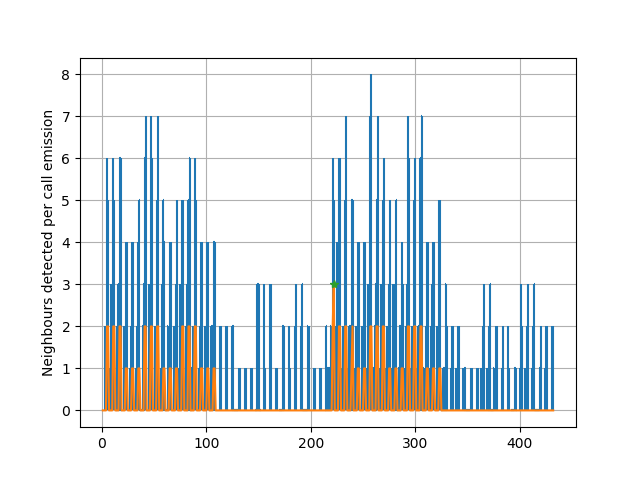

Text(0,0.5,'Neighbours detected per call emission')

In [30]:
by_paramid = all_run_data.groupby('param_id')
neighbours_by_params = [ np.array(df['detected_neighbours']) for value, df in by_paramid]
all_paramids = [value for value, df in by_paramid]
median_echoes = map(np.median, neighbours_by_params)
plt.figure()
plt.violinplot(neighbours_by_params)
plt.plot(np.arange(1,len(neighbours_by_params)+1),median_echoes)
best_paramset = np.argmax(median_echoes)
plt.plot(best_paramset+1, median_echoes[best_paramset],'*')
#plt.xticks([1,2],[1, 2.5]); plt.xlabel('Call/echo durations, milliseconds');
plt.grid()
plt.ylabel('Neighbours detected per call emission')

In [31]:
all_paramids[best_paramset]

'90*0.001*-1*0.5*100*0.1*True'

### Having done some visualisations - let's now do some regressions to understand how all of the variables contribute overall to the number of echoes a focal bat can actually detect:

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [33]:
all_run_data.head()

,atmospheric_attenuation,detected_neighbours,echocall_duration,heading_variation,implement_shadowing,interpulse_interval,min_spacing,np.random.seed,param_id,source_level
0,-1,1,0.0010,90,False,0.100,1.0,479679573,90*0.001*-1*1.0*100*0.1*False,100
1,-1,0,0.0010,90,True,0.025,1.0,287165708,90*0.001*-1*1.0*94*0.025*True,94
2,0,2,0.0010,90,False,0.100,1.0,193355102,90*0.001*0*1.0*100*0.1*False,100
3,0,0,0.0025,10,False,0.025,1.0,190997905,10*0.0025*0*1.0*100*0.025*False,100
4,-2,0,0.0010,10,True,0.050,1.0,134673671,10*0.001*-2*1.0*106*0.05*True,106


In [39]:
formula = 'detected_neighbours~heading_variation+atmospheric_attenuation \
            +implement_shadowing+interpulse_interval+min_spacing+source_level+echocall_duration'
model_num_echoes = smf.glm(formula, data=all_run_data, family = sm.families.NegativeBinomial(sm.families.links.log))

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  from ipykernel import kernelapp as app


In [40]:
model_num_echoes.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     detected_neighbours   No. Observations:                43200
Model:                             GLM   Df Residuals:                    43192
Model Family:         NegativeBinomial   Df Model:                            7
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -22380.
Date:                 Sat, 14 Sep 2019   Deviance:                       13213.
Time:                         15:15:22   Pearson chi2:                 2.02e+04
No. Iterations:                      9                                         
Covariance Type:             nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.7248      0.248     -6.968      0.000      -2.210      -1.240
implement_shadowing[T.True]     0.1825      0.023      7.783      0.000       0.137       0.228
heading_variation               0.0019      0.000      6.621      0.000       0.001       0.003
atmospheric_attenuation         0.0071      0.014      0.494      0.621      -0.021       0.035
interpulse_interval            46.6622      0.485     96.237      0.000      45.712      47.613
min_spacing                    -1.4056      0.048    -29.402      0.000      -1.499      -1.312
source_level                    0.0007      0.002      0.288      0.773      -0.004       0.005
echocall_duration           -1554.0730     20.778    -74.793      0.000   -1594.798   -1513.348
===============================================================================================
"""